In [80]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
from tqdm import tqdm
import itertools
import os

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


In [81]:
device = torch.device("cuda")

In [82]:
labels = ['bend', 'jack', 'jump', 'pjump', 'run', 'side', 'skip', 'walk', 'wave1', 'wave2']

In [83]:
data_dict = np.load("data\weizmann_dataset\processed_data\dataset.npz")
combined_data = []
combined_labels = []

# Loop through the dictionary to combine data and labels
for label, data_array in data_dict.items():
    # Append the data array entries to all_data
    combined_data.append(data_array)  # Keeps the (num_entries, 4, width, height) shape
    
    # Create a list of labels for each entry in this data_array and extend all_labels
    combined_labels.extend([label] * data_array.shape[0])

del(data_array)
# Concatenate all data along the first axis to create a single numpy array
combined_data = np.concatenate(combined_data, axis=0)  # Shape: (total_entries, 4, width, height)
combined_labels = np.array(combined_labels)             # Shape: (total_entries,)


# Convert each label in combined_labels to its corresponding index
label_indices = [labels.index(label) for label in combined_labels]

# Create a one-hot encoded array using np.eye
num_classes = len(labels)
one_hot_labels = np.eye(num_classes)[label_indices]  # Shape: (total_entries, num_classes)




indices = np.random.permutation(combined_data.shape[0])
shuffled_data = combined_data[indices]
shuffled_labels = one_hot_labels[indices]
del(combined_data, combined_labels, one_hot_labels, data_dict, label_indices)

print("Combined data shape:", shuffled_data.shape)
print("Combined labels shape:", shuffled_labels.shape)

Combined data shape: (503, 4, 15, 25)
Combined labels shape: (503, 10)


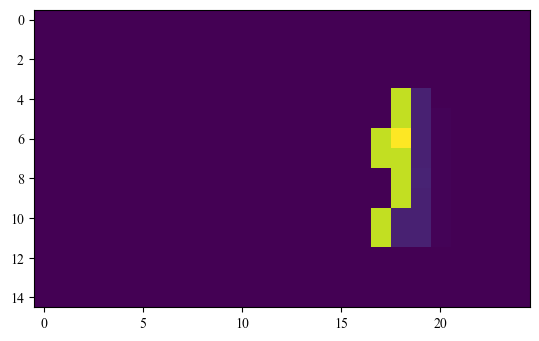

In [84]:
imgs = shuffled_data[100]/255

plt.imshow(
    (
        imgs[0]*1000+
        imgs[1]*100+
        imgs[2]*10+
        imgs[3]
    )
)

In [85]:
# Define the split ratios
train_ratio = 0.85
val_ratio = 0.0
test_ratio = 0.15

# Total number of entries
total_entries = shuffled_data.shape[0]

# Calculate split indices
train_end = int(total_entries * train_ratio)
val_end = train_end + int(total_entries * val_ratio)

# Split the data and labels
train_data = shuffled_data[:train_end]
train_labels = shuffled_labels[:train_end]

val_data = shuffled_data[train_end:val_end]
val_labels = shuffled_labels[train_end:val_end]

test_data = shuffled_data[val_end:]
test_labels = shuffled_labels[val_end:]

# Print shapes to verify
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)


Train data shape: (427, 4, 15, 25)
Train labels shape: (427, 10)
Validation data shape: (0, 4, 15, 25)
Validation labels shape: (0, 10)
Test data shape: (76, 4, 15, 25)
Test labels shape: (76, 10)


In [86]:
# Dictionary of all the rows of each mask-set in every file 
json_data = {
    "365nm":{
        "I1":range(0, 5),
        "I2":range(10, 15),
        "I3":range(18, 23),
        "I4":range(25, 30)
    },
    "455nm":{
        "I1":range(0, 5),
        "I2":range(7, 12),
        "I3":range(14, 19),
        "I4":range(21, 26)
    },
    "White":{
        "I1":range(0, 5),
        "I2":range(9, 14),
        "I3":range(16, 21),
        "I4":range(24, 29)
    }
}

In [87]:
combined_tables = []
for filename in ["White", "365nm", "455nm"]:
    path = "data/"+filename+".xlsx" 
    df = pd.read_excel(path, usecols='B:Q') # Read the excel sheet
    tables = [df.iloc[json_data[filename][key]].copy().reset_index(drop=True) for key in list(json_data[filename].keys())]
    combined_table = pd.concat(tables, axis=0)
    # combined_tables.append(combined_table)
    combined_tables.append(tables)
    del(df, tables, combined_table)

combined_tables[1] = [combined_tables[1][i].reindex(columns=combined_tables[0][0].columns) for i in range(4)]

In [88]:
NUMBER_OF_MASKS = 3
colour_indices = np.array([0, 1, 2])    # Three colours 365nm, 455 nm, White 
intensity_indices = np.array([0, 1, 2, 3])    # I1, I2, I3, I4
voltage_indices = np.array([4])    # rows in each of I1 to I4


# Generate a meshgrid of all combinations so that we don't sample the same triplet twice
colour_masks, intensity_masks, voltage_masks = np.meshgrid(
    colour_indices, intensity_indices, voltage_indices, indexing='ij'
)

# Flatten the arrays and stack them into an (N,3) array of unique 3D points
all_triplets = np.column_stack((colour_masks.ravel(), intensity_masks.ravel(), voltage_masks.ravel()))

# Randomly select unique 3D points
unique_indices = np.random.choice(all_triplets.shape[0], size=NUMBER_OF_MASKS, replace=False)
selected_triplets = all_triplets[unique_indices]

# Extract the selected masks
colour_masks = selected_triplets[:, 0]
intensity_masks = selected_triplets[:, 1]
voltage_masks = selected_triplets[:, 2]

# Uncomment to override

# colour_masks = np.array([1, 1, 1, 2, 2, 2, 1, 2])
# intensity_masks = np.array([1, 3, 2, 1, 2, 3, 1, 0])
# voltage_masks = np.array([4, 4, 4, 4, 4, 4, 3, 4])

colour_masks = np.array([1, 1, 1])
intensity_masks = np.array([1, 3, 2])
voltage_masks = np.array([4, 4, 4])
NUMBER_OF_MASKS = (len(colour_masks) == len(intensity_masks)) * len(colour_masks)

number_of_devices = 15 * 25 // 1
print("Selected Colour Masks:", colour_masks)
print("Selected Intensity Masks:", intensity_masks)
print("Selected Voltage Masks:", voltage_masks)

Selected Colour Masks: [1 1 1]
Selected Intensity Masks: [1 3 2]
Selected Voltage Masks: [4 4 4]


In [89]:
class CustomDataset(Dataset):
    def __init__(self, dataset:np.array,
                 labels:np.array,
                 combined_tables:list[pd.DataFrame],
                 colour_masks:np.array, 
                 intensity_masks:np.array, 
                 voltage_masks:np.array
                 ):
        self.processed_data = []
        self.labels = []

        dataset = (
            (dataset[:, 0, :, :]//255)*1000+
            (dataset[:, 0, :, :]//255)*100+
            (dataset[:, 0, :, :]//255)*10+
            (dataset[:, 0, :, :]//255)
        )
                

        for colour_mask, intensity_mask, voltage_mask in zip(colour_masks, intensity_masks, voltage_masks):
            mapping_dict = combined_tables[colour_mask][intensity_mask].loc[voltage_mask].to_dict()
            reservoir_output = np.vectorize(mapping_dict.get)(dataset)
            self.processed_data.append(reservoir_output)

        self.processed_data = np.concatenate(self.processed_data, axis=1) * 1e9
        # for i in range(len(colour_masks)):
        #     self.processed_data[:, i:i+30, :] = (self.processed_data[:, i:i+30, :] - self.processed_data[:, i:i+30, :].mean()) / (self.processed_data[:, i:i+30, :].std() + 1e-6)
        
        self.processed_data = self.processed_data.reshape((self.processed_data.shape[0], -1))

        self.labels = torch.tensor(labels, device=device).argmax(dim=1)
        self.processed_data = torch.tensor(self.processed_data, device=device)

    def __len__(self):
        return self.processed_data.shape[0]
    
    def __getitem__(self, index):
        return self.processed_data[index], self.labels[index]
    

In [90]:

BATCH_SIZE = 254
class ReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 10)
        self.activation = nn.functional.relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x = self.activation(self.fc(x))
        # x = self.softmax(x)
        # x = x.reshape(BATCH_SIZE, 1, NUMBER_OF_MASKS*144, 180)
        
        x = self.fc(x)
        return x
    

In [91]:
train_dataset = CustomDataset(train_data, train_labels, combined_tables, colour_masks, intensity_masks, voltage_masks)
# validation_dataset = CustomDataset(val_data, val_labels, combined_tables,  colour_masks, intensity_masks, voltage_masks)
test_dataset = CustomDataset(test_data, test_labels, combined_tables,  colour_masks, intensity_masks, voltage_masks)


train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(validation_dataset, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



tensor(3, device='cuda:0')


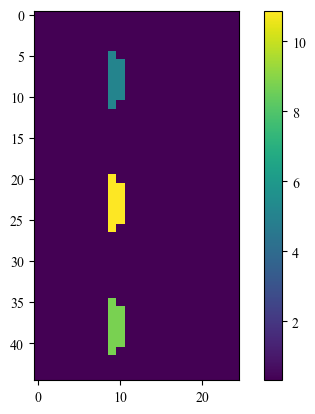

In [96]:
imgs = train_dataset[0][0].reshape(NUMBER_OF_MASKS*15, 25).cpu()
print(train_dataset.labels[128])
plt.imshow(imgs)
plt.colorbar()

In [93]:

EPOCHS = 300
learning_rate = 0.0005
# learning_rate = 1e-3

model = ReadoutLayer(number_of_devices*NUMBER_OF_MASKS).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=len(labels)).to(device)
precision = Precision(task="multiclass", num_classes=len(labels), average='macro').to(device)
recall = Recall(task="multiclass", num_classes=len(labels), average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=len(labels), average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=len(labels)).to(device)


In [94]:
print(len(labels))

10


In [95]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
        val_accuracy.append(accuracy.compute().item())
        val_precision.append(precision.compute().item())
        val_recall.append(recall.compute().item())
        val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

torch.Size([254, 10]) torch.Size([254])
torch.Size([173, 10]) torch.Size([173])
Epoch [1/300], Loss: 2.5766 Validation - Accuracy: 0.1499 Precision: 0.1368  Recall: 0.1412 F1 Score: 0.1219
torch.Size([254, 10]) torch.Size([254])
torch.Size([173, 10]) torch.Size([173])
Epoch [2/300], Loss: 2.2700 Validation - Accuracy: 0.1639 Precision: 0.1517  Recall: 0.1550 F1 Score: 0.1429
torch.Size([254, 10]) torch.Size([254])
torch.Size([173, 10]) torch.Size([173])
Epoch [3/300], Loss: 2.1357 Validation - Accuracy: 0.2178 Precision: 0.1962  Recall: 0.2057 F1 Score: 0.1947
torch.Size([254, 10]) torch.Size([254])
torch.Size([173, 10]) torch.Size([173])
Epoch [4/300], Loss: 2.0757 Validation - Accuracy: 0.2646 Precision: 0.2436  Recall: 0.2477 F1 Score: 0.2357
torch.Size([254, 10]) torch.Size([254])
torch.Size([173, 10]) torch.Size([173])
Epoch [5/300], Loss: 1.9448 Validation - Accuracy: 0.3115 Precision: 0.3219  Recall: 0.2909 F1 Score: 0.2880
torch.Size([254, 10]) torch.Size([254])
torch.Size([173

In [69]:
x = np.argmax(val_fscore)
print(val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

0.9578454494476318 0.9632487297058105 0.9613175392150879 0.9621269702911377


In [70]:
accuracy_df = pd.DataFrame({"Accuracy" :val_accuracy[0::10]})

# accuracy_df.to_excel("data/accuracy_metrics/temp.xlsx")


In [71]:
val_accuracy

[0.14051522314548492,
 0.2107728272676468,
 0.2388758808374405,
 0.2763465940952301,
 0.2927400469779968,
 0.35597190260887146,
 0.39344263076782227,
 0.40281030535697937,
 0.43325525522232056,
 0.4590163826942444,
 0.48946136236190796,
 0.5058547854423523,
 0.5245901346206665,
 0.5526931881904602,
 0.5854800939559937,
 0.601873517036438,
 0.6042154431343079,
 0.6159250736236572,
 0.6346604228019714,
 0.6533957719802856,
 0.6580796241760254,
 0.6580796241760254,
 0.6697892546653748,
 0.6814988255500793,
 0.6932084560394287,
 0.7025761008262634,
 0.6978922486305237,
 0.7072599530220032,
 0.7213114500045776,
 0.7283372282981873,
 0.7470725774765015,
 0.7423887848854065,
 0.7470725774765015,
 0.7540983557701111,
 0.7751756310462952,
 0.7845433354377747,
 0.7962529063224792,
 0.7915691137313843,
 0.7798594832420349,
 0.7845433354377747,
 0.7939109802246094,
 0.7962529063224792,
 0.8103044629096985,
 0.8266978859901428,
 0.8220140337944031,
 0.8337236642837524,
 0.8384075164794922,
 0.83840

In [72]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1:.4f}')

        

Test Accuracy: 95.78%
Test Precision: 96.3249%
Test Recall: 96.1318%
Test F1 Score: 0.9621


C:\Users\adith\AppData\Local\Temp\ipykernel_37080\2274749388.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


In [73]:
print(all_preds.dtype, all_labels.dtype)  # Should print torch.int64 or torch.int32
print(all_preds.min(), all_preds.max())  # Should be between 0 and 9
print(all_labels.min(), all_labels.max()) 

torch.int64 torch.int64
tensor(0, device='cuda:0') tensor(9, device='cuda:0')
tensor(0, device='cuda:0') tensor(9, device='cuda:0')


In [74]:
all_labels.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

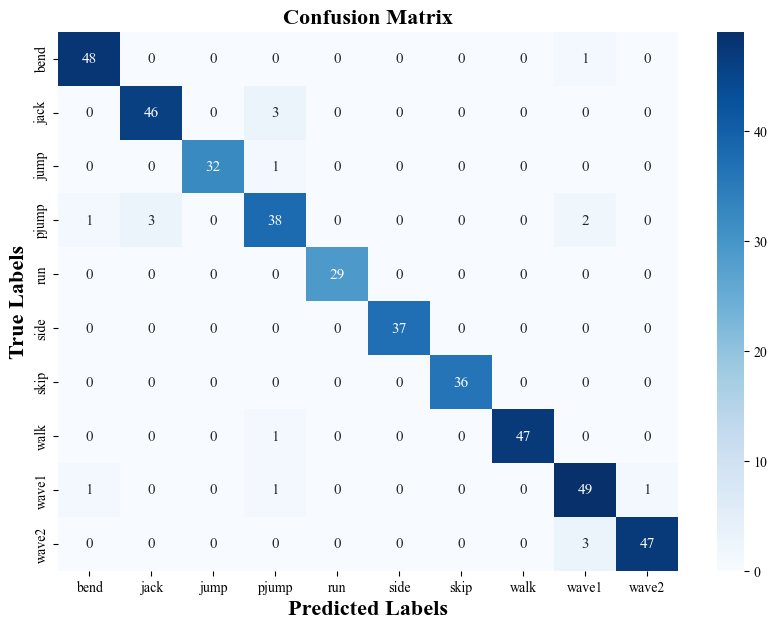

In [75]:
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix.cpu(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bend', 'jack', 'jump', 'pjump', 'run', 'side', 'skip', 'walk', 'wave1', 'wave2'], 
            yticklabels=['bend', 'jack', 'jump', 'pjump', 'run', 'side', 'skip', 'walk', 'wave1', 'wave2'],
            annot_kws={"size": 11, "family": "Times New Roman"})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.ylabel('True Labels', fontsize=16, fontweight='bold')
plt.show()

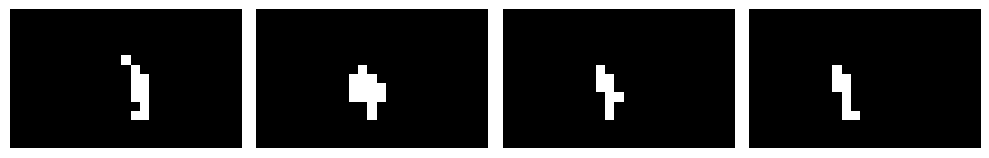

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (4 images of size 15x25)
images = train_data[1]  # Replace with your actual images

fig, axes = plt.subplots(1, 4, figsize=(10, 5))  # 1 row, 4 columns

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')  # Use cmap='gray' if they are grayscale images
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


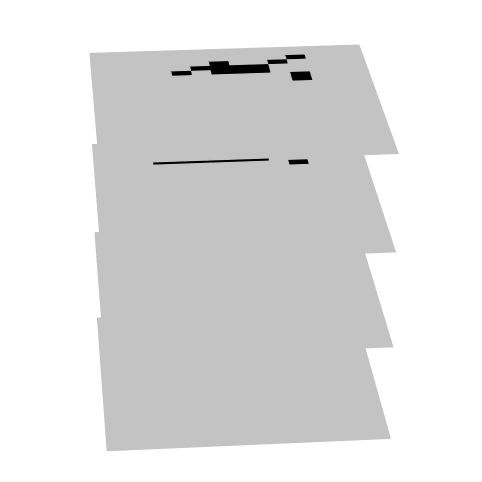

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgba

images = train_data[0]
images = (images < 0.5).astype(np.uint8)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# images = np.transpose(images, (0, 2, 1))  

# Define black and white colors as RGBA arrays
black = np.array(to_rgba('black'))  # (0, 0, 0, 1)
white = np.array(to_rgba('white'))  # (1, 1, 1, 1)
spacing = 30
# Plot each image at a different x-offset
for i in range(images.shape[0]):
    y, z = np.meshgrid(np.arange(images.shape[2]), np.arange(images.shape[1]))  
    x = np.full_like(y, i * spacing) 

    face_colors = np.where(images[i][..., None] == 1, white, black)  

    ax.plot_surface(y, z, x-15, facecolors=face_colors, rstride=1, cstride=1)

ax.view_init(elev=25, azim=-5)  
ax.axis("off")

ax.set_xlim([0, images.shape[2]])
ax.set_ylim([0, images.shape[1]])
ax.set_zlim([0, images.shape[0] * spacing * 0.55])

plt.show()


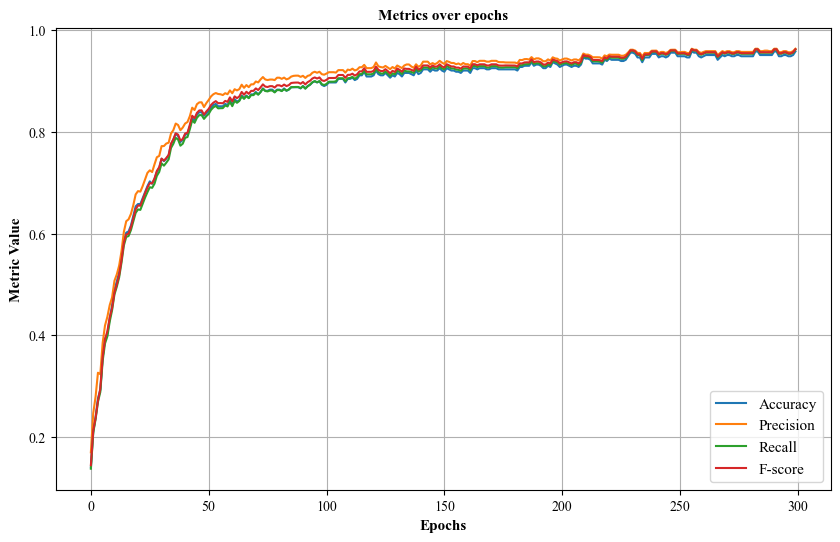

In [78]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], val_accuracy, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], val_precision, label='Precision')
plt.plot([i for i in range(len(val_recall))], val_recall, label='Recall')
plt.plot([i for i in range(len(val_fscore))], val_fscore, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()